In [1]:
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage

# Исследование поведения клиентов сети фитенес-центров

Отток клиентов является распрестранненой проблемой для сервисов. Индикаторы говорящие о потенциальных клиентских потерях зависят от специфики отрасли. В целях борьбы с оттоком, отдел по работе с клиентами фитнес-центра "Культурист-датасаентист" перевел клиентские анкеты в электронный вид, и предоставил полученные данные для анализа. В рамках исследования, для формирования стратегии удержания клиентов, необходимо научиться прогнозировать вероятность оттока клиента, сформировать типичные портреты клиентов и проанализировать основные признаки оттока посетителей.

## Загрузка данных

Из имеющегося файла выгрузим данные и превратим в датафрейм:

In [3]:
df = pd.read_csv('gym_churn.csv')
df.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [4]:
print('Размер датафрейма:', df.shape)

Размер датафрейма: (4000, 14)


In [5]:
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 0


In [6]:
df.columns = [i.lower() for i in df] 
df.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

Данные получены и подлежат дальнейшей предобработке.

## Проведение исследовательского анализа (EDA)

Подготовим данные к исследованию. Проверим его на отсутствующие значения, приемлимость типов данных в столбцах и наличие "артефактов":

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Пропущенные значения в данных отсутствуют. Все данные приведены к нужным типам.

In [8]:
df[['contract_period', 'age', 'avg_additional_charges_total', 'month_to_end_contract', 'lifetime','avg_class_frequency_total', 'avg_class_frequency_current_month']].describe()

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,4.681250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052
std,4.549706,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906
min,1.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000
25%,1.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003
50%,1.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574
75%,6.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336
max,12.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783


Данные параметров: contract_period, month_to_end_contract, lifetime имеют отностельно большие показатели стандартного отклонения, а их медиана значительно отличаются от средних. Возможно в них присутствуют "артефактные" значения.

In [9]:
df_group = df.groupby('churn').mean().T
df_group

churn,0,1
gender,0.510037,0.510839
near_location,0.873086,0.768143
partner,0.534195,0.355325
promo_friends,0.353522,0.183789
phone,0.903709,0.902922
contract_period,5.747193,1.728558
group_visits,0.464103,0.268615
age,29.976523,26.989632
avg_additional_charges_total,158.445715,115.082899
month_to_end_contract,5.283089,1.662582


In [10]:
churn_0 = df[df['churn'] == 0]
churn_1 = df[df['churn'] == 1]

In [11]:
churn_0.shape[0]

2939

Хорошо видно, что средние значения признаков для оставшихся пользователей больше, чем для ушедших. Это связано с тем, что выборки для оставшихся и ушедших пользователей соотносятся примерно 3 : 1.

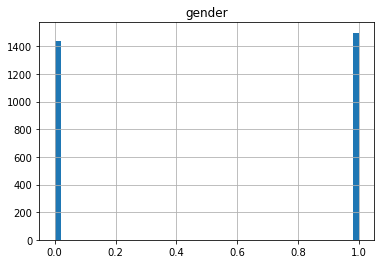

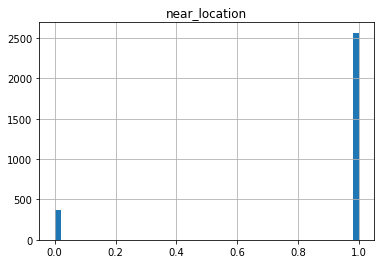

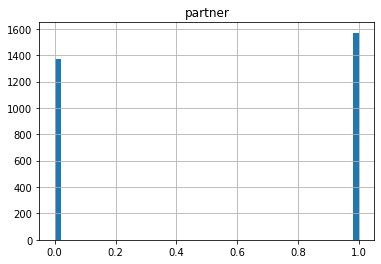

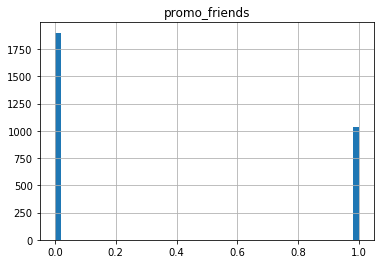

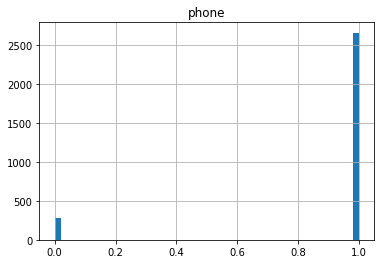

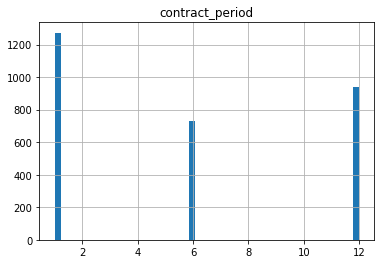

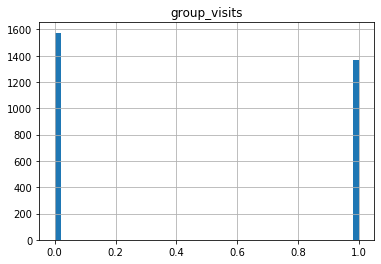

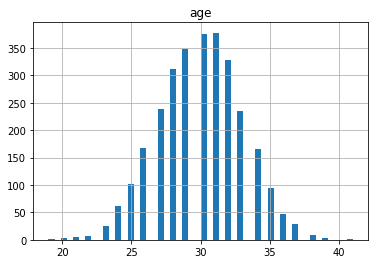

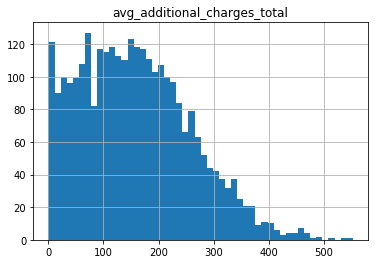

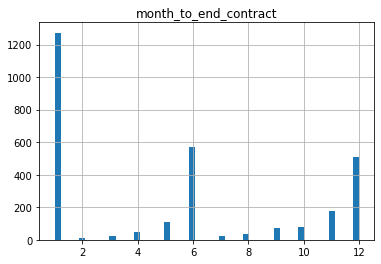

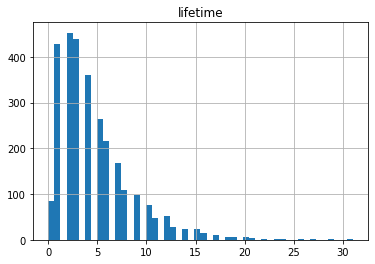

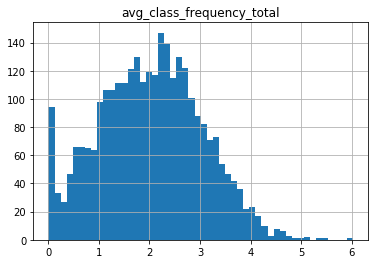

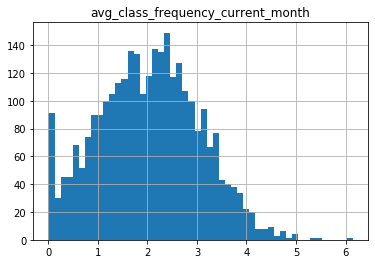

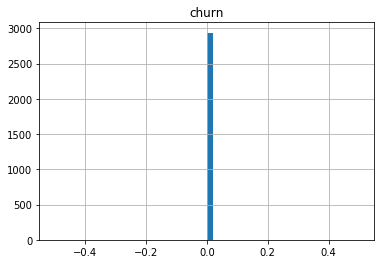

In [12]:
for i in churn_0.columns:
    churn_0[i].hist(bins=50)
    plt.title(i)
    plt.show()

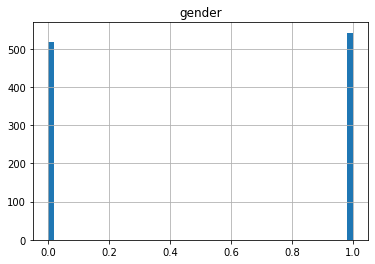

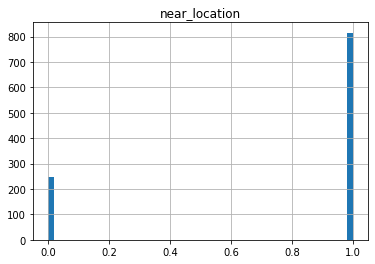

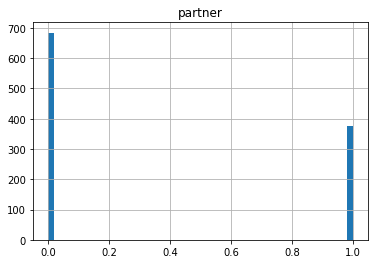

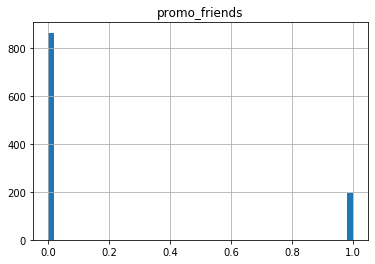

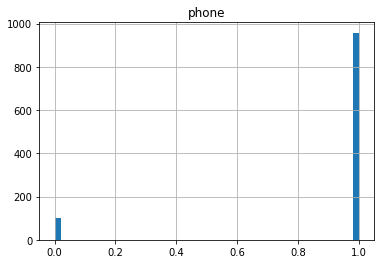

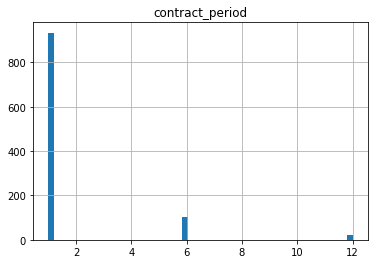

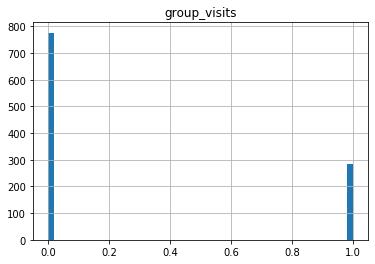

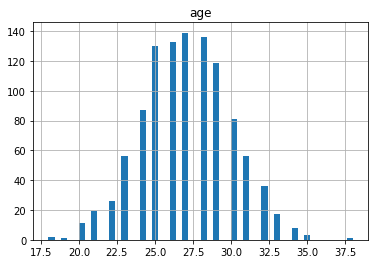

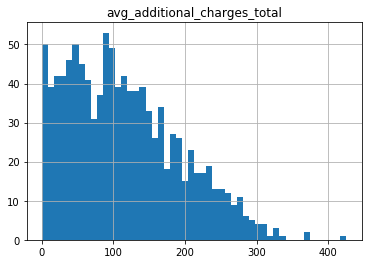

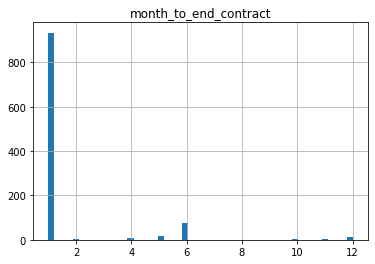

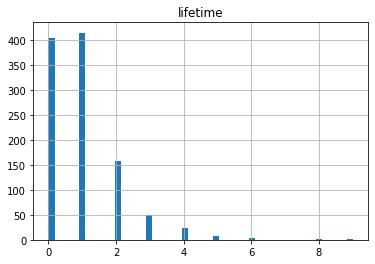

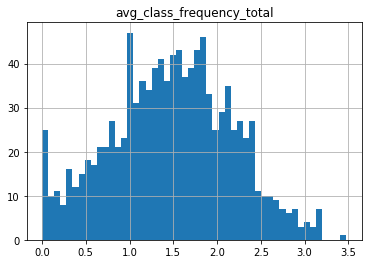

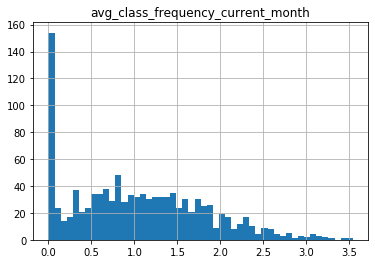

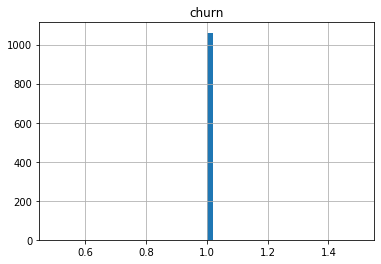

In [13]:
for i in churn_1.columns:
    churn_1[i].hist(bins=50)
    plt.title(i)
    plt.show()

На гистограммах наблюдаются незначительно отклоняющиеся значения, но можно сказать, что все они находятся в допустимых пределах.

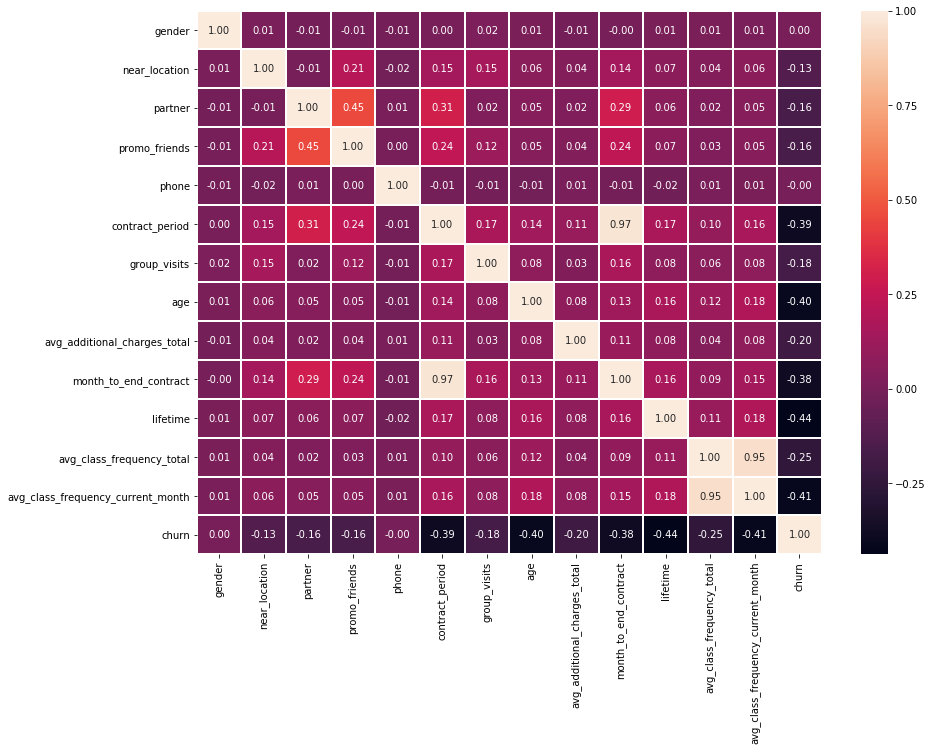

In [14]:
cor = df.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(cor, annot = True, fmt = '0.2f', linewidths=1)
plt.show()

На тепловой карте хорошо видны мультиколлинеарные признаки:
- contract_period - month_to_end_contract
- avg_class_frequency_current_month - avg_class_frequency_total

Так же можно наблюдать признаки с нулевой корреляцией к целевой переменной:
- phone
- gender

Исследовательский анализ данных произведен. Есть некоторые особенности, которые нужно учесть для определенных моделей обучения. Но в целом данные готовы к дальнейшим исследованиям.

## Построение модели прогнозирования оттока клиентов

Необходимо построить модель бинарной классификации клиентов, для которых целевым признаком является факт оттока клиента в следующем месяце. Для этого разобъем данные на обучающую и валидационную выборки, обучим модель логистической регрессией и случайным лесом, а затем сравним модели по их метрикам.

### Логистическая регрессия

In [15]:
X = df.drop('churn', axis=1)
y = df['churn']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [17]:
model = LogisticRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [18]:
print('Accuracy : {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Accuracy : 0.93
Precision: 0.86
Recall: 0.83


### Случайный лес

In [19]:
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) 
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test) 

C:\Users\Satellite\anaconda3\envs\praktikum\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):
C:\Users\Satellite\anaconda3\envs\praktikum\lib\site-packages\sklearn\utils\fixes.py:223: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


In [20]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


Согласно полученным параметрам, можно сказать, что алгоритм логистической регрессии для нашего случая проявил себя лучше, чем случайный лес.

## Кластеризация клиентов

Стандартизируем данные, отбросим столбец 'churn' и произведем кластеризацию:

In [21]:
df_cl = df.drop('churn', axis=1)

scaler = StandardScaler()
x_cl = scaler.fit_transform(df_cl)

col = df_cl.columns
df_cl = pd.DataFrame(x_cl, columns = col)
df_cl.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,0.979706,0.427881,1.026861,1.497161,-3.059852,0.289890,1.194032,-0.056554,-1.377531,0.161605,-0.193329,-1.911920,-1.678472
1,-1.020715,0.427881,-0.973842,-0.667931,0.326813,1.608822,1.194032,0.557327,-0.350213,1.831941,0.873680,0.045176,0.136014
2,-1.020715,0.427881,1.026861,-0.667931,0.326813,-0.809219,-0.837498,-0.363494,-0.181592,-0.792873,-0.460081,-0.020493,-0.029019
3,-1.020715,0.427881,1.026861,1.497161,0.326813,1.608822,1.194032,1.171208,-0.874722,1.831941,-0.460081,1.364655,1.510450
4,0.979706,0.427881,1.026861,1.497161,0.326813,-0.809219,-0.837498,-0.977375,0.533700,-0.792873,-0.193329,-0.787076,-0.614542


In [22]:
linked = linkage(df_cl, method = 'ward')

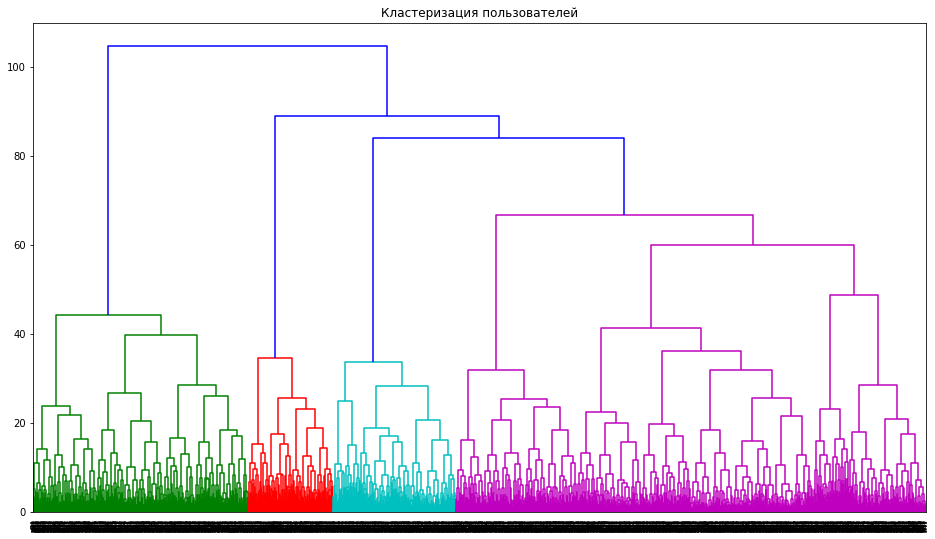

In [23]:
plt.figure(figsize=(16, 9))  
dendrogram(linked, orientation = 'top')
plt.title('Кластеризация пользователей')
plt.show()

Согласно дендрограмме я бы предположил, что стоит выделить 6 кластеров пользователей.

In [24]:
km = KMeans(n_clusters = 5, random_state=0)
labels = km.fit_predict(df_cl)
df['cluster'] = labels

In [25]:
df.cluster.value_counts()

3    1262
0    1011
4     837
2     505
1     385
Name: cluster, dtype: int64

In [26]:
df.groupby('cluster').mean().T

cluster,0,1,2,3,4
gender,0.502473,0.522078,0.495050,0.485737,0.560335
near_location,0.959446,0.862338,0.000000,1.000000,0.976105
partner,0.783383,0.470130,0.463366,0.350238,0.356033
promo_friends,0.574679,0.306494,0.079208,0.240095,0.229391
phone,1.000000,0.000000,1.000000,1.000000,0.998805
contract_period,10.884273,4.787013,2.352475,1.948494,2.665472
group_visits,0.543027,0.425974,0.215842,0.341521,0.473118
age,29.980218,29.301299,28.477228,28.167987,30.127838
avg_additional_charges_total,160.706969,143.957664,135.457501,131.622204,161.724258
month_to_end_contract,9.950544,4.475325,2.198020,1.856577,2.455197


In [27]:
sns.set(style='darkgrid')

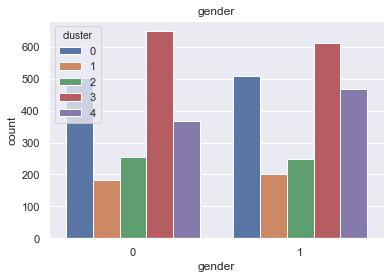

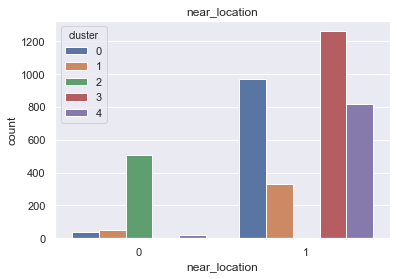

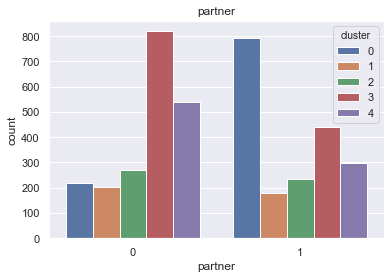

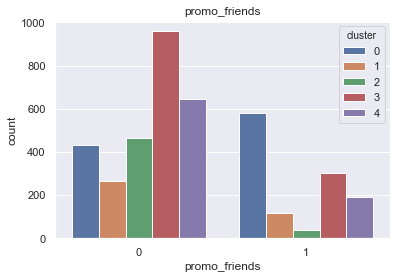

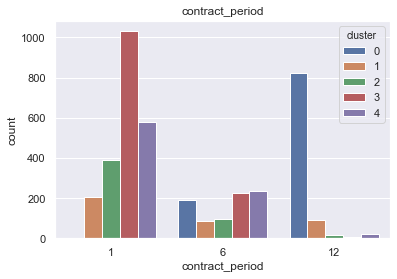

In [28]:
for i in ['gender', 'near_location', 'partner', 'promo_friends', 'contract_period']:
    sns.countplot(x = df[i], hue='cluster', data=df)
    plt.title(i)
    plt.show()

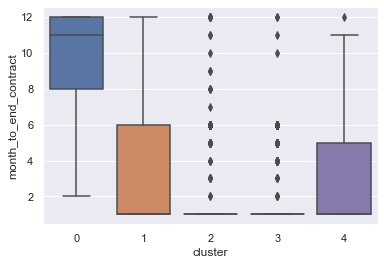

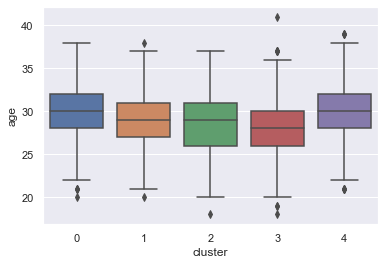

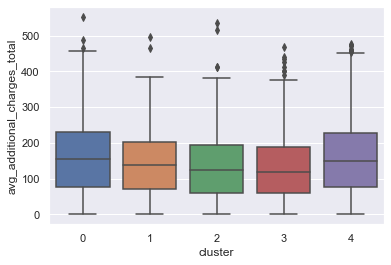

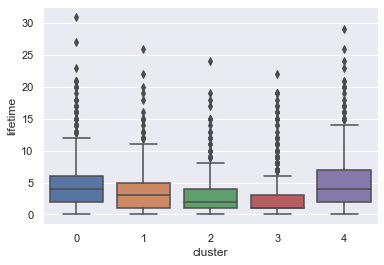

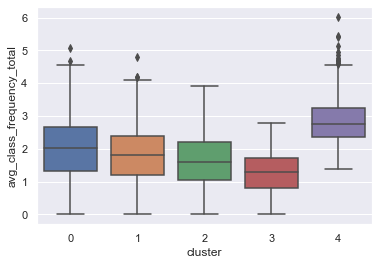

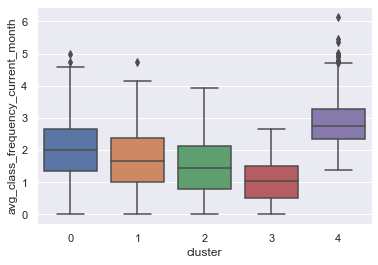

In [29]:
for i in ['month_to_end_contract', 'age', 'avg_additional_charges_total', 'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']:
    sns.boxplot(x = 'cluster', y = df[i], data = df)
    plt.show()

По полученным данным можно сказать, что кластеры неравнозначны по количеству клиентов и доле оттока. Так например, кластеры 2 и 3 обладают наибольшим оттоком, а кластеры 0 и 4, наоборот наименьшим.

Можно сказать "надежные" кластеры обладают следующими признаками:
- наибольшая продолжительность оформленного абонемента;
- высокая сумма расходов на дополнительные услуги;
- высокий lifetime;
- высокая частота посещений в неделю за предыдущий месяц;
- повыщенная частота посещения групповых занятий.

## Формулировка выводов и рекомендаций

Для повышения прибыльности сети финтес-центров следует:
- поддерживать низкий отток для "надежных" кластеров, мотивируя их пользователей;
- политику закупки трафика и привличения пользователей нужно скорректировать опираясь на опыт "надежных" кластеров, равняясь на них;
- более тщательно подойти к сегментированию оттекающих, к каждому сегменту тестировать индивидуальные предложения;
- выстроить предиктивную систему аналитики, действуя на опережение потенциального оттока клиентов.